# Initialisation

In [85]:
%matplotlib inline
import pandas as pd
# pd.set_option('display.max_rows', None)        # à décommenter si on veut afficher tout le dataframe
import numpy as np
import os
import sys
import datetime
import json
import requests

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import colors as mcolors
colors = mcolors._colors_full_map
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import PowerNorm
from matplotlib.colors import LightSource

import geopandas as gpd
from scipy.interpolate import RegularGridInterpolator
from termcolor import colored                     # coloration du texte
import xarray as xr                               # gestion des xarray
import cartopy.crs as ccrs                        # cartographie
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
from tabulate import tabulate                     # impression du texte dans un format tabulé
import yaml
import plotly.express as px
from scipy import stats                           # calage d'une tendance linéaire pour les températures
from shapely.vectorized import contains
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
import rioxarray
from rasterio.enums import Resampling

plt.rcParams['text.usetex'] = True                # paramètres latex
plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('default')
date_calcul        = datetime.date.today()
année_en_cours     = date_calcul.year 
################################
## Auteur : Christoophe Ancey ##
## Date : Mai 2024            ##
## Mise à jour : juin 205     ##
################################

#-------------------------------------------
# Lecture du fichier de postes  
#-------------------------------------------
# adresse du répertoire de travail
répertoire_base      = '/home/ancey/Météo-France/'
répertoire_principal = répertoire_base + 'meteo.data/base'
print("Je suis dans le répertoire : ", répertoire_base)
# teste si le répertoire existe
if not os.path.exists(répertoire_principal):
    # s'il n'existe pas le créer
    os.makedirs(répertoire_principal)
    print("J'ai créé le répertoire : ", répertoire_principal)
else:
    print("J'ai trouvé le répertoire : ", répertoire_principal)
 
os.chdir(répertoire_principal)
print("Je me place dans le répertoire : "+os.getcwd())





Je suis dans le répertoire :  /home/ancey/Météo-France/
J'ai trouvé le répertoire :  /home/ancey/Météo-France/meteo.data/base
Je me place dans le répertoire : /home/ancey/Météo-France/meteo.data/base


In [2]:
fichier_yaml = répertoire_base+'station_safran.yaml'
with open(fichier_yaml, 'r',encoding='utf-8') as file:
        paramètres = yaml.safe_load(file)
 

paramètres


{'poste': 'Mont Cenis',
 'commune': 'Mont Cenis',
 'dossier': '/home/ancey/Météo-France/postes/Mont_Cenis_73144001',
 'longitude': 6.899167,
 'latitude': 45.269333,
 'variables': {'pluie': True,
  'neige': True,
  'manteau': False,
  'TN': True,
  'TX': True,
  'TM': True}}

In [3]:
nom_poste    = paramètres['poste']
nom_commune  = paramètres['commune']      
existe_pluie = paramètres['variables']['pluie']       
existe_neige = paramètres['variables']['neige'] 
existe_HN    = paramètres['variables']['manteau'] 
existe_TN    = paramètres['variables']['TN'] 
existe_TX    = paramètres['variables']['TX'] 
existe_TM    = paramètres['variables']['TM'] 
répertoire_résultats = paramètres['dossier']
longitude_poste      = paramètres['longitude']
latitude_poste       = paramètres['latitude']  


os.chdir(répertoire_résultats)
print("Je me place dans le répertoire : "+os.getcwd()) 
données_neige = pd.read_pickle(répertoire_résultats+'/données_neige.pkl')
données_pluie = pd.read_pickle(répertoire_résultats+'/données_pluie.pkl')

Je me place dans le répertoire : /home/ancey/Météo-France/postes/Mont_Cenis_73144001


# Connexion

In [4]:
# Récupération des informations
url_service='https://api.geosas.fr/edr/collections/safran-isba/'
r=requests.get(url_service,   verify=True) 
data_info=r.json()
if r.status_code == 200:
    print("La connexion est établie.")
else :
    print(colored("Il y a une erreur avec le code : {:d}.".format(r.status_code), 'red') )

La connexion est établie.


In [5]:
# outils de conversion des coordonnées
import pyproj

source_crs = 'epsg:2154' # Coordinate system of the file
target_crs = 'epsg:4326' # Global lat-lon coordinate system

# fonctions de conversion RGF93 <-> WGS
lambert_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
latlon_to_lambert = pyproj.Transformer.from_crs( target_crs,source_crs)

In [6]:
# Liste toutes les variables possibles
liste_variables_possibles = [['Nom',"Définition","unité"]]
for parametre in list(data_info['parameter_names']):
    name=data_info['parameter_names'][parametre]
    liste_variables_possibles.append([parametre, name['description'] ,name['unit']['label']])
print(colored("Liste des variables accessibles :",'cyan'))
print(tabulate(liste_variables_possibles))

Liste des variables accessibles :
--------  -----------------------------------------------------------  ---------------------
Nom       Définition                                                   unité
DLI_Q     Rayonnement atmosphérique (cumul quotidien)                  Joule par centimètre²
DRAINC_Q  Drainage (cumul quotidien 06-06 UTC)                         millimetre
ETP_Q     Evapotranspiration potentielle (formule de Penman-Monteith)  millimetre
FF_Q      Vent (moyenne quotidienne)                                   mètre par seconde
HU_Q      Humidité relative (moyenne quotidienne)                      Pourcentage
PRELIQ_Q  Précipitations liquides (cumul quotidien 06-06 UTC)          millimetre
PRENEI_Q  Précipitations solide (cumul quotidien 06-06 UTC)            millimetre
SSI_Q     Rayonnement visible (cumul quotidien)                        Joule par centimètre²
SWI_Q     Indice d'humidité des sols (moyenne quotidienne 06-06 UTC)   Pourcentage
TINF_H_Q  Température minim

# Données station

In [7]:
# nom du poste
nom_poste = "Val Cenis" # nom
# coordonnées en RGF93 du poste
x_poste, y_poste = latlon_to_lambert.transform(latitude_poste,longitude_poste)

translation_x = 000 # rajout de 3 km


x_poste       = x_poste+translation_x
param_name = 'PRENEI_Q,PRELIQ_Q,T_Q'
#projection='EPSG:4326'
#coord='POINT('+str(latitude_poste)+" "+str(longitude_poste)+")"
#coord='POINT(1011370 6471230)'
coord      = 'POINT('+str(x_poste)+' '+str(y_poste)+')'
projection = 'EPSG:2154'
formatage  = 'CoverageJSON'
date       = '1959-01-01/2024-05-31'
requete    = f'https://api.geosas.fr/edr/collections/safran-isba/position?coords={coord}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete, verify=True)
data=r.json()
if r.status_code == 200:
    print("J'ai récupéré les données.")
else :
    print(colored("Il y a une erreur avec le code : {:d}.".format(r.status_code), 'red') )

# coordonnées du noeud RGF93
x_safran = data['domain']['axes']['x']['values'] 
y_safran = data['domain']['axes']['y']['values'] 
# coordonnées du noeud WGS
lat_safran, lon_safran = lambert_to_latlon.transform(x_safran,y_safran)
# la grille SAFRAN est 8*8 km² donc il faut convertir pour avoir cela en lat, long : 
# 1° = 111 km en latitude et 111 km * cos(latitude) pour la longitude
delta_y = 4/111
delta_x = 4/111/np.cos(lat_safran[0]*3.14/180.)


#Coordonnées de la zone à représenter
lat_min, lat_max  = latitude_poste -0.7, latitude_poste +0.7
lon_min, lon_max  = longitude_poste-0.9, longitude_poste+0.5
central_longitude = (lon_min + lon_max) / 2
central_latitude  = (lat_min + lat_max) / 2
 

https://api.geosas.fr/edr/collections/safran-isba/position?coords=POINT(1005650.5953364202 6470879.453527486)&crs=EPSG:2154&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=CoverageJSON&datetime=1959-01-01/2024-05-31
J'ai récupéré les données.


In [8]:
safran_temps         = data['domain']['axes']['t']['values']
safran_neige         = np.array(data['ranges']['PRENEI_Q']['values'])
safran_précipitation = np.array(data['ranges']['PRENEI_Q']['values'])+np.array(data['ranges']['PRELIQ_Q']['values'])
série_safran_neige   = pd.DataFrame()
série_safran_neige['neige'] = safran_neige
série_safran_neige['date']  = pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')

série_safran_précipitation   = pd.DataFrame()
série_safran_précipitation['précipitation'] = safran_précipitation
série_safran_précipitation['date']          = pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')
display(série_safran_neige)

neige       date
0        0.0 1959-01-01
1        5.5 1959-01-02
2        9.4 1959-01-03
3        8.7 1959-01-04
4        3.5 1959-01-05
...      ...        ...
23888    2.7 2024-05-27
23889    0.0 2024-05-28
23890    0.1 2024-05-29
23891    1.3 2024-05-30
23892    0.4 2024-05-31

[23893 rows x 2 columns]

Le maximum a été atteint le 24/11/2016 avec un cumul journalier de 108.3 mm.


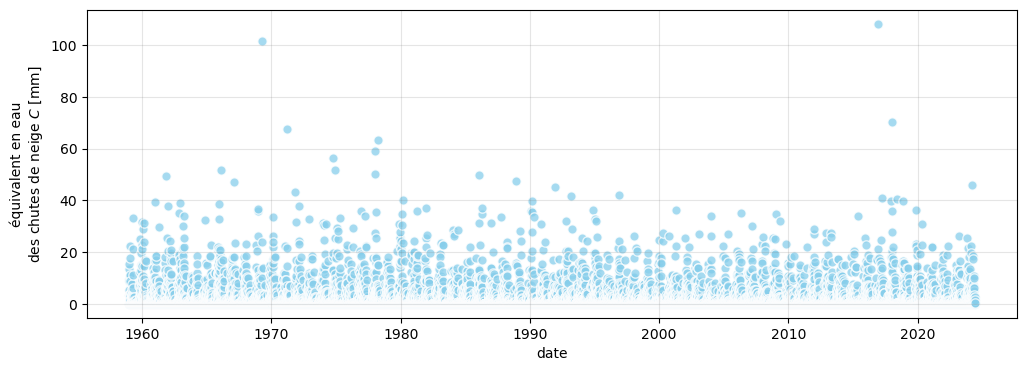

In [9]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(série_safran_neige['date'], série_safran_neige['neige'], marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 0.75)
ax.set_ylabel(r'équivalent en eau' '\n' r'des chutes de neige $C$ [mm]')
ax.set_xlabel(r'date')
max_neige = np.nanmax(safran_neige)
date_max= série_safran_neige[série_safran_neige['neige']==max_neige]['date'] .values[0]   
# le format de données du temps est bizarre il faut supprimer les 10 dernier caractères
date_max=datetime.datetime.strptime(str(date_max)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_neige))   
plt.grid(True, color = 'gray', alpha=0.2)

#fig.savefig("Cumul_précipitations(RR)_Safran.pdf",bbox_inches='tight')
fig.savefig(répertoire_résultats+'/'+"Cumul_précipitations(RR_neige)_Safran.png",bbox_inches='tight',dpi=300)

In [10]:
unité_comparaison = 'W' # W: week, ME: month, YE: year
sel2=données_pluie.resample(unité_comparaison, on='date')['pluie'].sum()
#dernière_année_nulle = 2024
#if dernière_année_nulle.year != 2021:
      #début_sélection_mesure = dernière_année_nulle
      #fin_sélection_mesure = données_pluie['date'].values[-1]
      #selection_mesure =sel2[sel2.index>début_sélection_mesure]
#else:
début_sélection_mesure = données_pluie['date'].values[0]
fin_sélection_mesure = "2023-12-31"
selection_mesure =sel2[sel2.index<=fin_sélection_mesure]

cumul_safran=série_safran_neige.resample(unité_comparaison, on= 'date').sum()
filtrage_date = (cumul_safran.index> début_sélection_mesure) & (cumul_safran.index <= fin_sélection_mesure)
selection_safran = np.array(cumul_safran[filtrage_date])

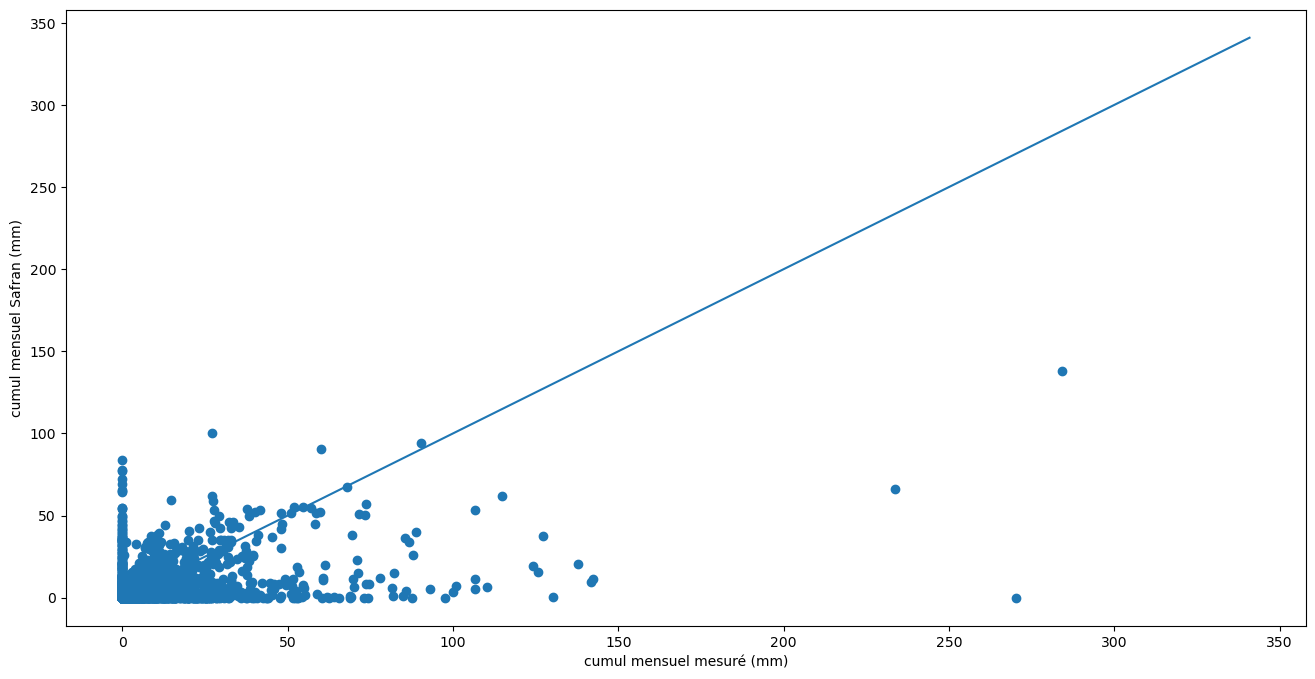

In [11]:
if selection_mesure.size == selection_safran.size:
      fig, ax = plt.subplots(figsize=(16,8))
      x = np.linspace(0,max(sel2)*1.2,10)
      ax.plot(x,x)
      ax.scatter(x=selection_mesure,y=selection_safran)
      ax.set_xlabel("cumul mensuel mesuré (mm)")
      ax.set_ylabel("cumul mensuel Safran (mm)")
      fig.savefig(répertoire_résultats+'/'+'comparaison_mesures2032_safran.pdf')
else:
      print(colored("Il faut ajuster la période des données car les deux échantillons n'ont pas la même longueur.",'red'))

In [12]:
# -----------trace une carte plotly avec le point de maille en spécifiant le nom de la trace pour la légende   

fig = px.scatter_mapbox(lat= lat_safran, lon= lon_safran, mapbox_style= "open-street-map", 
                        color_discrete_sequence= [ 'red'],
                        title= 'Noeud SAFRAN du poste de mesure', height= 800, width= 1200,
                        zoom = 10, 
                        # labels= 'Maille la plus proche'
                       hover_name= ['Maille la plus proche'],    
                      )

fig.add_trace(go.Scattermapbox(lat= lat_safran, lon= lon_safran, mode= 'markers', marker= {'size': 10, 'color': 'red'}, name= 'Noeud Safran', ))
fig.add_trace(go.Scattermapbox(lat= [latitude_poste], lon= [longitude_poste], mode= 'markers', marker= {'size': 10, 'color': 'blue'}, name= 'Poste de mesure', ))
#fig.add_trace(go.Scattermapbox(lat= [lat_safran-0.036,lat_safran+0.036], lon= [lon_safran-0.036,lon_safran+0.036], 
#                               mode= 'markers', marker= {'size': 8, 'color': 'black'}, name= 'limites maille Safran', ))


fig.add_trace(go.Scattermapbox(
    mode = "markers+lines", name= 'limites',
    lon = [lon_safran[0]-delta_x, lon_safran[0]-delta_x, lon_safran[0]+delta_x, lon_safran[0]+delta_x,lon_safran[0]-delta_x], 
    lat = [lat_safran[0]-0.036, lat_safran[0]+0.036, lat_safran[0]+0.036, lat_safran[0]-0.036,lat_safran[0]-0.036],
    marker = {'size': 5}))


fig.write_image('carte_localisation_mesures2032_safran.png') 
fig

# Cartes et masques

## Masques et grilles d'interpolation

In [13]:
fichier = "/home/ancey/Cartographie/carte_France/georef-france-region-millesime.shp"

regions = gpd.read_file(fichier)
# Sélection des régions de métropole
regions = regions[regions.reg_area_co == 'FXX']   # Classement par ordre alphabétique
regions = regions.sort_values(by = 'reg_name_up') # Réinitialisation de l'index
regions = regions.reset_index(drop = True)

# On choisit la région Rhône-Alpes
position =  int(np.array(np.where(np.array(regions['reg_name_up'])=='RHONE-ALPES') ) [0,0])
region_choisie = regions.iloc[position]
# cas 2 : pays -> France
# Source du fichier : https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
fichier = "/home/ancey/Cartographie/carte_France/europe/europe.shp"
pays    = gpd.read_file(fichier)
position    =  int(np.array(np.where((np.array(pays['NAME'])=='France') & (np.array(pays['CONTINENT'])=='Europe')) ) [0,0])
pays_choisi = pays.iloc[position]

In [ ]:
# Interpolation du xarray
new_lon = np.linspace(lon_min, lon_max, 2000)   
new_lat = np.linspace(lat_min, lat_max, 2000)

# grille de type mesh
lon_grid, lat_grid = np.meshgrid(new_lon, new_lat)

# masque pour la france
coarse_mask = contains(pays_choisi.geometry, lon_grid.ravel(), lat_grid.ravel())
coarse_mask = coarse_mask.reshape(lon_grid.shape)

pas = 1                                                      # pas = 1 => pas de zoom
france_mask = zoom(coarse_mask.astype(float), pas, order=1)  # order=1 => bilinéaire si on zoome
france_mask = france_mask > 0.5                              # seuil fixé à 50 % pour la détection

# à modifier si le seuil déforme le pourtour des frontières
#france_mask = france_mask[:len(new_lat), :len(new_lon)]

## Villes

In [15]:
# Choix de villes pour la carte
# source : https://planete-excel.fr/liste-des-communes-de-france-au-format-excel/
# On sélectionne les villes de plus de 4000 hab dans le 73 et le 05
liste_villes = pd.read_excel('/home/ancey/Cartographie/carte_France/Communes-de-France-2023.xlsx')
villes_région = liste_villes[(liste_villes['Population']>4000) & ((liste_villes['Région']=='Auvergne-Rhône-Alpes') | 
                             (liste_villes['Région']=="Provence-Alpes-Côte d'Azur") )] \
      [['Nom (minuscules)','Département','Latitude','Longitude','Population']]
#choix_villes = np.array( villes_région[( (villes_région['Département']=='Savoie') |  (villes_région['Département']=='Haute-Savoie')) &
#                                                                                                  (villes_région['Longitude']>6)   ])
choix_villes = np.array( villes_région[ (villes_région['Département']=='Savoie') & (villes_région['Longitude']>6.2)      ])
print(tabulate(choix_villes))

-----------------------  ------  -------  -------  -----
Aime-la-Plagne           Savoie  45.5554  6.64679   4537
Albertville              Savoie  45.6693  6.39087  20414
Bourg-Saint-Maurice      Savoie  45.6193  6.76884   7561
Saint-Jean-de-Maurienne  Savoie  45.2726  6.34989   7894
Ugine                    Savoie  45.7545  6.41405   7366
-----------------------  ------  -------  -------  -----


## Hydrologie

In [16]:
fichier_rivière = '/home/ancey/Cartographie/hydrosheds/rivières_alpes.gpkg'
fichier_lac = '/home/ancey/Cartographie/hydrosheds/lacs_alpes.gpkg'
lacs = gpd.read_file(fichier_lac)
rivières = gpd.read_file(fichier_rivière)

## Code couleurs

In [17]:
couleurs_précipitation = [
    (0.00, "#00008B"),  # Deep Blue
    (0.15, "#0000CD"),
    (0.30, "#0000FF"),
    (0.50, "#ADD8E6"),
    (0.75, "#FFFFE0"),
    (1.00, "#FFD700")
]

custom_cmap = LinearSegmentedColormap.from_list("EnhancedBlue", couleurs_précipitation)
custom_cmap_r = custom_cmap.reversed()

## MNT Alpes

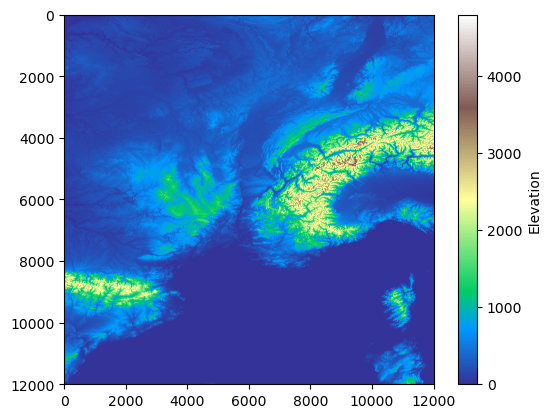

In [18]:
# données MNT Alpes tirées de https://ec.europa.eu/eurostat/web/gisco/geodata/digital-elevation-model/copernicus#Elevation

mnt_adresse = "/home/ancey/Cartographie/DEM/10_DEM_y40x0.tif"
elevation_da = rioxarray.open_rasterio(mnt_adresse, masked=True)
elevation_2d = elevation_da.squeeze()

# Now plot
plt.imshow(elevation_2d, cmap='terrain', origin='upper')
plt.colorbar(label='Elevation')
plt.show()

In [19]:
# Découpage pour les besoins
 
cadre_limite      = (lon_min, lat_min, lon_max, lat_max)
carte_extension   = [lon_min, lon_max, lat_max, lat_min]  
elevation_clipped = elevation_da.rio.clip_box(*cadre_limite).squeeze()
 

# Extraction des données
elevation = elevation_clipped.values
lon = elevation_clipped['x'].values
lat = elevation_clipped['y'].values
# Vérification
if lat[0] < lat[-1]:
    lat = lat[::-1]
    elevation = elevation[::-1, :]

# création d'un relief par ombrage
ls        = LightSource(azdeg=315, altdeg=45)
hillshade = ls.shade(elevation, cmap=plt.cm.Greys, blend_mode='overlay')


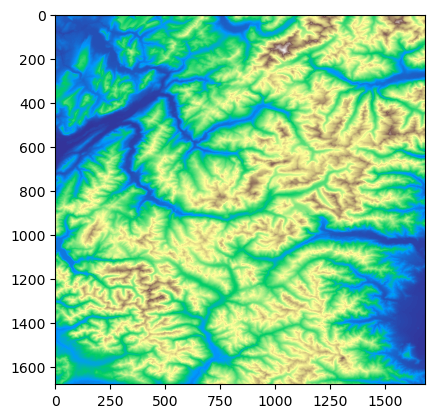

In [20]:
plt.imshow(elevation_clipped, cmap='terrain', origin='upper')

## Fonctions de traçage

In [61]:
def fond_topographique(longitude_poste, latitude_poste, nom_poste:str, offset=(-0.9,0.5,-.7,0.7),taille = (18,15),projection='normal'):
    """ 
    fournit le fond topographique
    données :
    * longitude_poste, 
    * latitude_poste, 
    * nom_poste: string
    * offset: (offset_x_min, offset_x_max, offset_y_min, offset_y_max)
      fournit la taille de l'image par rapport aux coordonnées du poste
    * taille: (18,15)
    * projection='normal' si on choisit "lambert", la carte aura une projection de type
      Lambert conforme (le temps de traçage est deux fois plus grand)
    """
    #Coordonnées de la zone à représenter
    offset_x_min, offset_x_max, offset_y_min, offset_y_max = offset
    lat_min, lat_max  = latitude_poste +offset_y_min, latitude_poste +offset_y_max
    lon_min, lon_max  = longitude_poste+offset_x_min, longitude_poste+offset_x_max
    central_longitude = (lon_min + lon_max) / 2
    central_latitude  = (lat_min + lat_max) / 2

    fig = plt.figure(figsize=taille, facecolor = 'w')
    if projection == 'lambert':
        ax = plt.axes(projection = ccrs.LambertConformal(central_longitude = central_longitude,
                                                    central_latitude = central_latitude))
    else:
        ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.75, linestyle='-')
    gl.xlabel_style = {'size': 12, 'color': 'gray','rotation':0}
    gl.ylabel_style = {'size': 12, 'color': 'gray','rotation': 90}
    gl.top_labels = False
    gl.right_labels = False

    # villes
    plt.scatter( x= longitude_poste, y = latitude_poste, color = 'black', transform=ccrs.PlateCarree(), zorder = 200)
    plt.text( longitude_poste,latitude_poste+0.01, nom_poste, horizontalalignment='center',
            fontsize = 14, weight = 'bold', transform=ccrs.PlateCarree(), zorder = 200)
    for villes in choix_villes: 
            plt.scatter(x = villes[3], y= villes[2], marker = '+', color = 'black',transform=ccrs.PlateCarree(), zorder = 200)
            plt.text(villes[3], villes[2]+.02, villes[0],fontsize = 12, horizontalalignment='center' , transform=ccrs.PlateCarree(), zorder = 200)
    # relief
    ax.imshow(
        hillshade[::-1],
        extent=carte_extension,
        transform=ccrs.PlateCarree(),
        origin='upper',
        zorder=0,
        alpha=0.9
    )
    # hydrologie
    rivières.plot(
        ax=ax,  # Plot on the same axis
        color=mcolors.CSS4_COLORS['powderblue'],
        linewidth=1,
        alpha=0.7,
        zorder=50,   
        transform=ccrs.PlateCarree()   
    )
    lacs.plot(
        ax=ax,  # Plot on the same axis
        color=mcolors.CSS4_COLORS['powderblue'] ,
        linewidth=0.8,
        alpha=0.9,
        zorder=50,   
        transform=ccrs.PlateCarree()   
    )
        #Affichage des côtes, frontières et océans
    ax.coastlines(zorder = 101)
    ax.add_feature(cfeature.BORDERS, zorder = 101, edgecolor = 'orange', ls = '--',linewidth=3)
    #ax.add_feature(cfeature.OCEAN, zorder = 99, edgecolor = 'lightgray')
    ax.add_feature(cfeature.STATES,linewidth=0.5 )
    return fig, ax

def tracer(neige,cmap=custom_cmap_r,projection='normal',titre='précipitations (mm)',taille=(15,12),pas=200,calcul_valeur_min = False,offset=(-0.9,0.5,-.7,0.7),gamma=0.6):
    """ 
    trace le xarray eneige sur le fond topgraphique appelé par la fonction fond_topographique
    arguments :
    * cmap       = color map. Par défaut, la plage de couleurs définie par custom_cmap_r,
    * projection = projection du système de coordonnées. Par défaut projection classique
    * titre      = nom de la barre de couleurs
    * taille     = taille du graphique. Par défaut taille=(15,12)
    * pas        = incrément pour les contours. Par défaut, pas = 200 mm
    * calcul_valeur_min [Boolean] : si oui, on calcule la valeur minimale du xarray neige, si non, on prend valmin = 0
    * offset     = taille de la carte
    * gamma      = distorsion de l'échelle de couleur. Par défaut gamma = 0.6
    """
    neige_interpolation = neige.interp(x=new_lon, y=new_lat, method='linear')  
    # Application du masque
    neige_masque = neige_interpolation.where(france_mask)  
    #  1 — lissage
    neige_lisse= gaussian_filter(neige_masque.values, sigma=1)
    #  2 — interpolation sur grille fine
    interp_func = RegularGridInterpolator((neige_masque.y.values, neige_masque.x.values), neige_lisse)
    x_new = np.linspace(neige_masque.x.min(), neige_masque.x.max(), neige.x.size * 2)
    y_new = np.linspace(neige_masque.y.min(), neige_masque.y.max(), neige.y.size * 2)
    X_new, Y_new = np.meshgrid(x_new, y_new)
    points = np.array([Y_new.ravel(), X_new.ravel()]).T
    Z_new = interp_func(points).reshape(Y_new.shape)
    valmax = np.ceil(np.max(neige_masque ).values/100)*100
    if calcul_valeur_min:
         valmin = np.floor(np.min(neige_masque ).values/100)*100
    else:
         valmin = 0
    # appel du fon topo
    fig, ax = fond_topographique(longitude_poste,latitude_poste,nom_poste,taille=(15,12),projection=projection,offset=offset)
    im = neige_masque.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=valmin, vmax=valmax,
        cmap=cmap  ,
        norm=PowerNorm(gamma=gamma),
        alpha=0.75,
        robust=False,
        add_colorbar=False
    )
    #contours lines
    contour_levels = np.arange(valmin,valmax,pas)  
    contours = ax.contour(
        x_new, y_new, Z_new,
        levels=contour_levels,
        colors='red',
        alpha = 0.8,
        linewidths=0.8,
        transform=ccrs.PlateCarree()
    )
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')
    cb = plt.colorbar(im, orientation="vertical", pad=0.05)
    cb.set_label(label=titre, fontsize=14)#,weight='bold')
    cb.ax.tick_params(labelsize='large')

    return fig, ax
 

# Cartes 2024

In [22]:
param_name = 'PRENEI_Q,PRELIQ_Q,T_Q'
box        = str(longitude_poste-1)+","+str(latitude_poste-1)+","+str(longitude_poste+1)+","+str(latitude_poste+1)
 
projection = 'EPSG:4326'
formatage  = 'NetCDF4'
date       = '2024-01-01/2024-12-31'  # à modifier selon besoin
requete=f'https://api.geosas.fr/edr/collections/safran-isba/cube?bbox={box}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete)
if r.status_code == 200:
    print("requete ok")
else :
    print("erreur code :", r.status_code)

https://api.geosas.fr/edr/collections/safran-isba/cube?bbox=5.899167,44.269333,7.899167,46.269333&crs=EPSG:4326&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=NetCDF4&datetime=2024-01-01/2024-12-31
requete ok


In [23]:
data   = xr.open_dataset(r.content)
# calcul du cumul de neige
neige  = data.PRENEI_Q.sum(dim="time") #ds2
data

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 366, y: 27, x: 25)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
  * y            (y) float64 216B 46.31 46.23 46.15 46.07 ... 44.4 44.32 44.24
  * x            (x) float64 200B 5.982 6.061 6.141 6.221 ... 7.737 7.817 7.896
Data variables:
    PRENEI_Q     (time, y, x) float32 988kB nan nan 0.0 0.0 ... nan nan nan nan
    PRELIQ_Q     (time, y, x) float32 988kB ...
    T_Q          (time, y, x) float32 988kB ...
    spatial_ref  int32 4B ...
Attributes:
    description:  Données quotidiennes du modèle de simulation des schémas de...
    id:           safran-isba
    title:        Safran-Isba, Données changement climatique - SIM quotidienne
    crs:          EPSG:4326
    rel:          https://www.etalab.gouv.fr/licence-ouverte-open-licence/

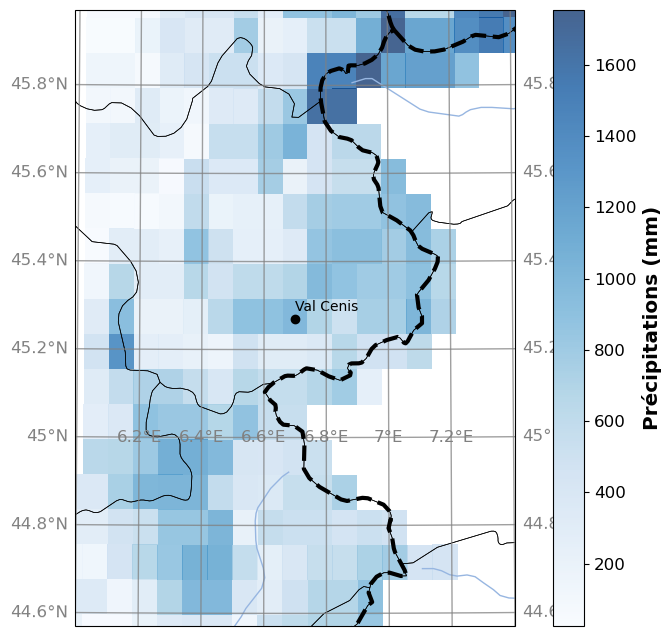

In [24]:
neige_positive    = neige.where(neige>0)               # on ne garde que les valeurs numériques


cmap = 'Blues'
#Initialisation de la figure    
fig = plt.figure(figsize=(10,8), facecolor = 'w')
ax  = plt.axes(projection = ccrs.LambertConformal(central_longitude = central_longitude,
                                                 central_latitude = central_latitude))
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.75, linestyle='-')
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}
#Affichage des côtes, frontières et océans
ax.coastlines(zorder = 101)
ax.add_feature(cfeature.BORDERS, zorder = 101, edgecolor = 'black', ls = '--',linewidth=3)
ax.add_feature(cfeature.OCEAN, zorder = 99, edgecolor = 'lightgray')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES,linewidth=0.5 )


im = neige_positive.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  
    # usual xarray stuff
    cbar_kwargs = None,
    #cbar_kwargs={"orientation": "vertical", "shrink": 0.75 },
    add_colorbar=False,
    robust=True, 
    alpha = 0.75, 
    cmap  = cmap
)
ax.scatter( longitude_poste,latitude_poste,color = 'black')
ax.text( longitude_poste,latitude_poste+2000,nom_poste)

cb = plt.colorbar(im, orientation="vertical", pad=0.05)
cb.set_label(label='Précipitations (mm)', fontsize='x-large',weight='bold')
cb.ax.tick_params(labelsize='large')
# relief
#ax.add_image(relief, 12)
plt.show()

In [25]:
# Export
fig.savefig(répertoire_résultats+'/'+"extrait-Safran-2024.png",bbox_inches='tight')

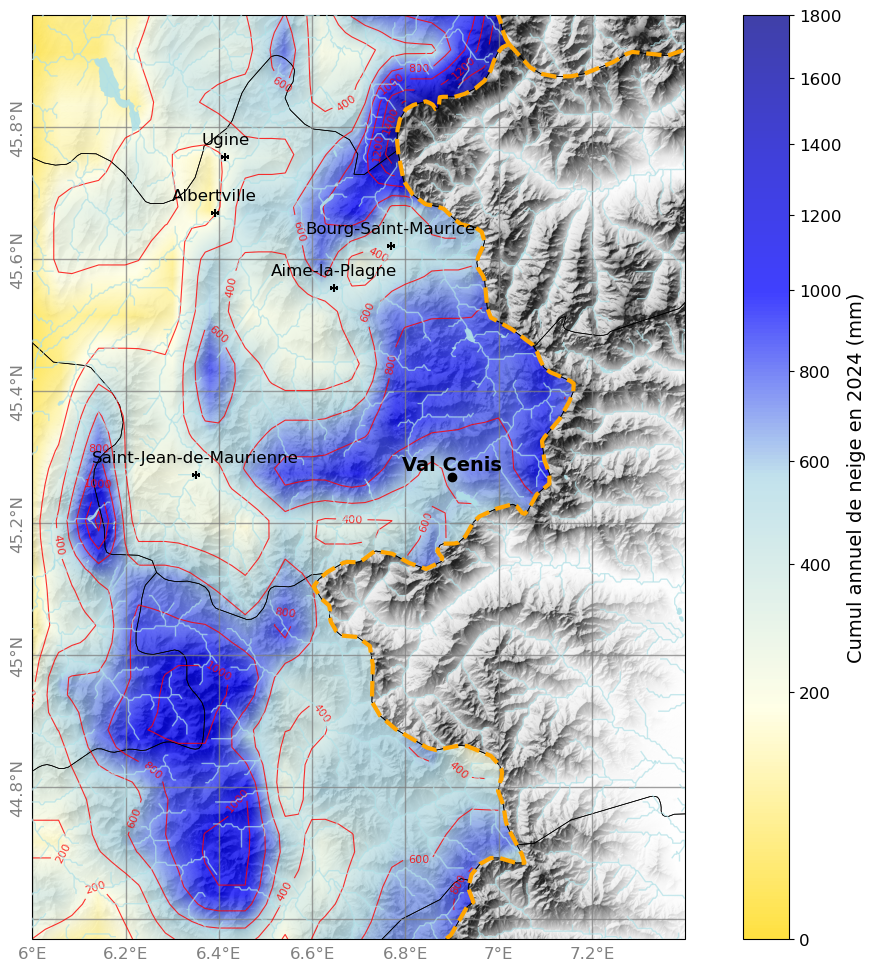

In [26]:
fig, _ = tracer(neige,titre='Cumul annuel de neige en 2024 (mm)')

In [27]:
#fig, _ = tracer(neige,projection='normal',cmap='viridis_r',titre='cumul de neige (mm)')

In [28]:
print(f"Cumul sur {nom_poste} : {neige.sel(x=longitude_poste,y=latitude_poste,method="nearest").values:0.1f} mm.")

Cumul sur Val Cenis : 755.1 mm.


In [29]:
fig.savefig(répertoire_résultats+'/'+f'cumul_annuel_{année_en_cours-1}.png',dpi=300,bbox_inches='tight')

In [30]:
variabilité_cumul = []
for i in range(-1,2):
      for j in range(-1,2):
            x=neige_positive.sel(x=longitude_poste+2*i*delta_x,y=latitude_poste+2*j*delta_y,method="nearest").x.values
            y=neige_positive.sel(x=longitude_poste+2*i*delta_x,y=latitude_poste+2*j*delta_y,method="nearest").y.values
            cumul24 = neige_positive.sel(x=longitude_poste+2*i*delta_x,y=latitude_poste+2*j*delta_y,method="nearest").values
            z = cumul24
            variabilité_cumul.append(cumul24)
            print(" x = ",np.round(x,3)," y = ",np.round(y,3),": cumul ",int(z), "(noeud ", i," - ", j, ")")
print(f"Le cumul moyen sur le secteur est {int(np.mean(variabilité_cumul))} mm avec un écart-type {int(np.std(variabilité_cumul))} mm.")

 x =  6.779  y =  45.195 : cumul  365 (noeud  -1  -  -1 )
 x =  6.779  y =  45.274 : cumul  695 (noeud  -1  -  0 )
 x =  6.779  y =  45.354 : cumul  974 (noeud  -1  -  1 )
 x =  6.939  y =  45.195 : cumul  479 (noeud  0  -  -1 )
 x =  6.939  y =  45.274 : cumul  755 (noeud  0  -  0 )
 x =  6.939  y =  45.354 : cumul  799 (noeud  0  -  1 )
 x =  7.019  y =  45.195 : cumul  479 (noeud  1  -  -1 )
 x =  7.019  y =  45.274 : cumul  755 (noeud  1  -  0 )
 x =  7.019  y =  45.354 : cumul  799 (noeud  1  -  1 )
Le cumul moyen sur le secteur est 678 mm avec un écart-type 184 mm.


# Cartes du cumul moyen de neige 1960-présent

In [31]:
param_name='PRENEI_Q,PRELIQ_Q,T_Q'
 

box=str(longitude_poste-1)+","+str(latitude_poste-1)+","+str(longitude_poste+1)+","+str(latitude_poste+1)
 
projection='EPSG:4326'
formatage='NetCDF4'
date='1960-01-01/2023-12-31'
date='1960-01-01/'+str(année_en_cours-1)+'-12-31'
requete=f'https://api.geosas.fr/edr/collections/safran-isba/cube?bbox={box}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete)
if r.status_code == 200:
    print("requete ok")
else :
    print("erreur code :", r.status_code)

https://api.geosas.fr/edr/collections/safran-isba/cube?bbox=5.899167,44.269333,7.899167,46.269333&crs=EPSG:4326&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=NetCDF4&datetime=1960-01-01/2024-12-31
requete ok


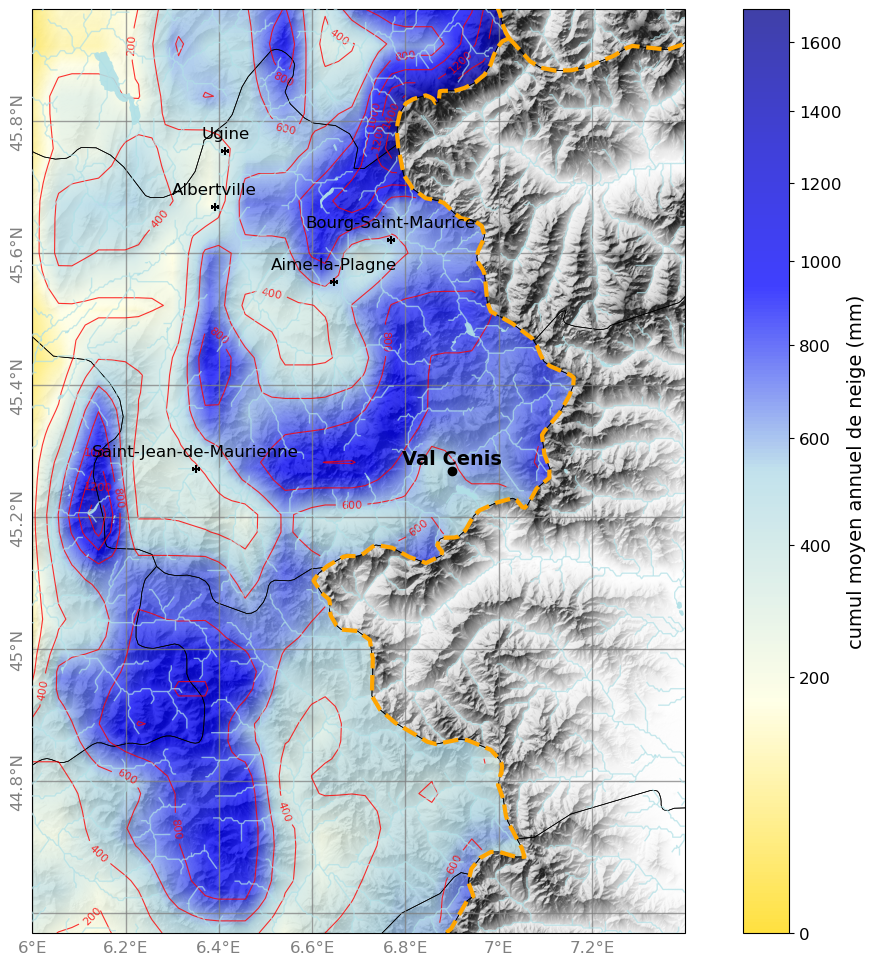

In [32]:
data       = xr.open_dataset(r.content)
nombre_ans = int(date[11:15])-int(date[0:4])+1
neige      = data.PRENEI_Q.sum(dim="time")/nombre_ans # on divise la somme par le nombre d'années

 

fig,_ = tracer(neige,titre='cumul moyen annuel de neige (mm)')

In [33]:
fig.savefig(répertoire_résultats+'/'+f'cumul_annuel_moyen_neige.png',dpi=300,bbox_inches='tight')

In [34]:
print(f"Le cumul moyen des chutes de neige sur {nom_poste} est de \
{int(neige.sel(x=longitude_poste,y=latitude_poste,method="nearest").values )} mm sur la période 1960-{année_en_cours-1}.")

Le cumul moyen des chutes de neige sur Val Cenis est de 663 mm sur la période 1960-2024.


In [35]:
variabilité_cumul = []
for i in range(-1,2):
      for j in range(-1,2):
            x=neige.sel(x=longitude_poste+2*i*delta_x,y=latitude_poste+2*j*delta_y,method="nearest").x.values
            y=neige.sel(x=longitude_poste+2*i*delta_x,y=latitude_poste+2*j*delta_y,method="nearest").y.values
            cumul24 = neige.sel(x=longitude_poste+2*i*delta_x,y=latitude_poste+2*j*delta_y,method="nearest").values
            z = cumul24
            variabilité_cumul.append(cumul24)
            print(" x = ",np.round(x,3)," y = ",np.round(y,3),": cumul ",int(z), "(noeud ", i," - ", j, ")")
print(f"Le cumul moyen sur le secteur est {int(np.mean(variabilité_cumul))} cm avec un écart-type {int(np.std(variabilité_cumul))} cm.")


 x =  6.779  y =  45.195 : cumul  474 (noeud  -1  -  -1 )
 x =  6.779  y =  45.274 : cumul  781 (noeud  -1  -  0 )
 x =  6.779  y =  45.354 : cumul  1034 (noeud  -1  -  1 )
 x =  6.939  y =  45.195 : cumul  455 (noeud  0  -  -1 )
 x =  6.939  y =  45.274 : cumul  663 (noeud  0  -  0 )
 x =  6.939  y =  45.354 : cumul  685 (noeud  0  -  1 )
 x =  7.019  y =  45.195 : cumul  455 (noeud  1  -  -1 )
 x =  7.019  y =  45.274 : cumul  663 (noeud  1  -  0 )
 x =  7.019  y =  45.354 : cumul  685 (noeud  1  -  1 )
Le cumul moyen sur le secteur est 655 cm avec un écart-type 174 cm.


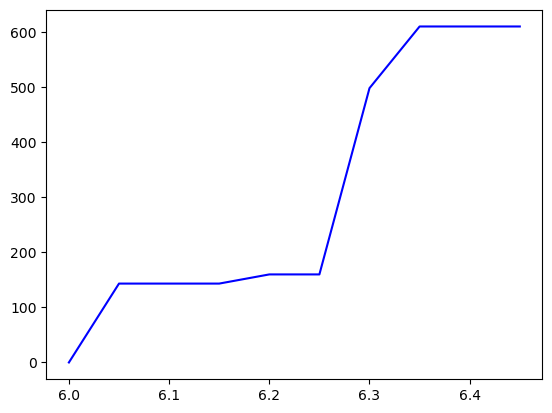

In [36]:
#Profil de cumul le long de la latitude 45,27° selon trois méthodes
xx = np.arange(6,6.5,0.05)
yl = 46
zz2= [float(neige.sel(x=x,y=yl,method="nearest").values ) for x in xx]

 
plt.plot(xx,zz2,'b')

# Valeurs extrêmes de neige

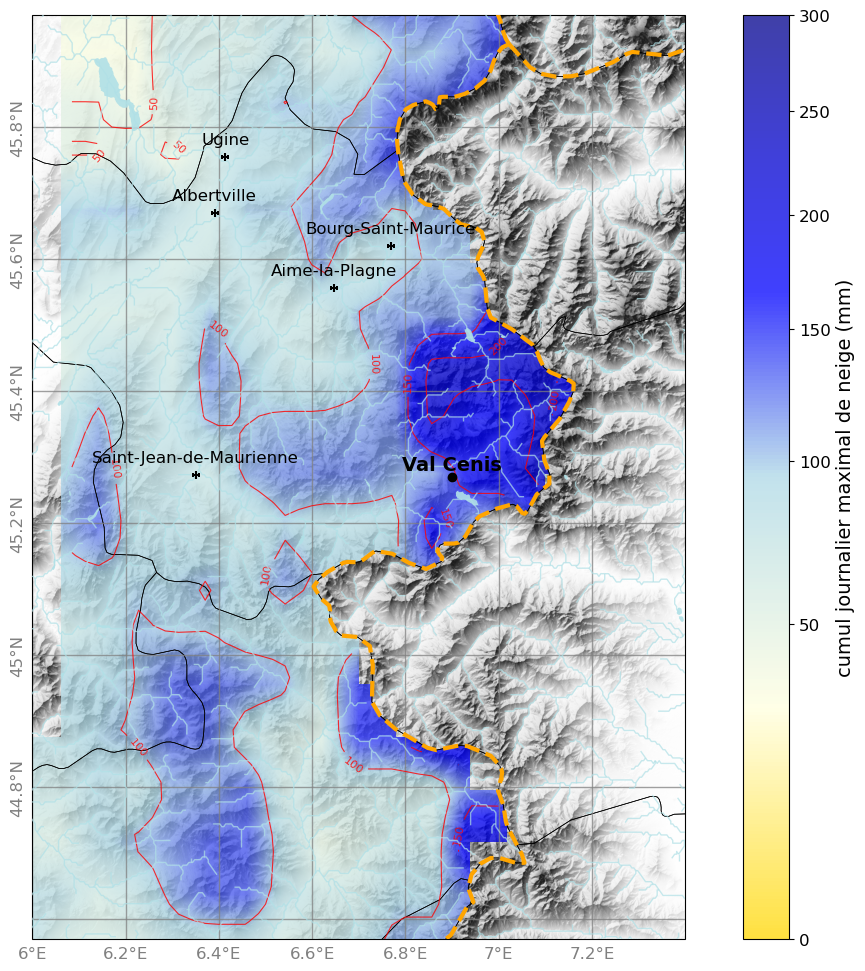

In [37]:
data       = xr.open_dataset(r.content)
nombre_ans = int(date[11:15])-int(date[0:4])+1
neige      = data.PRENEI_Q.max(dim="time") 

fig, _ = tracer(neige,titre='cumul journalier maximal de neige (mm)',pas=50)

In [38]:
fig.savefig(répertoire_résultats+'/'+"cumul_journalier_neige_max.png",bbox_inches='tight',dpi=300)

In [39]:
print(f"Le cumul max des chutes de neige sur {nom_poste} est de \
{int(neige.sel(x=longitude_poste,y=latitude_poste,method="nearest").values )} mm sur la période 1960-{année_en_cours-1}.")

Le cumul max des chutes de neige sur Val Cenis est de 177 mm sur la période 1960-2024.


# Précipitations totales max

In [59]:
data       = xr.open_dataset(r.content)
nombre_ans = int(date[11:15])-int(date[0:4])+1
précipitations_extrêmes = (data.PRELIQ_Q+data.PRENEI_Q).max(dim="time")


 

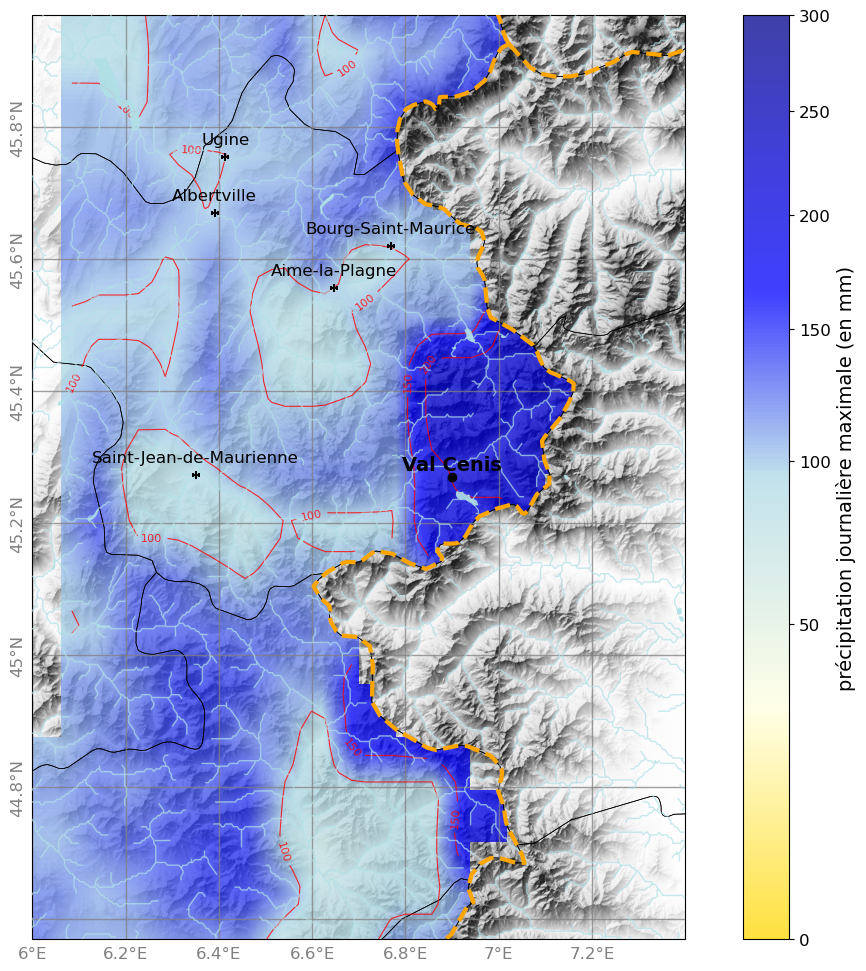

In [62]:
fig, _ = tracer(précipitations_extrêmes,titre='précipitation journalière maximale (en mm)',calcul_valeur_min=True, pas =50, gamma = 0.6)

In [63]:
fig.savefig(répertoire_résultats+'/'+"précipitation_journalière_maximale.png",bbox_inches='tight',dpi=300)

In [43]:
print(f"Le cumul max des préciputations sur {nom_poste} est de \
{int(précipitations_extrêmes.sel(x=longitude_poste,y=latitude_poste,method="nearest").values )} mm sur la période 1960-{année_en_cours-1}.")

Le cumul max des préciputations sur Val Cenis est de 210 mm sur la période 1960-2024.


# Précipitations totales moyennes

In [44]:
data       = xr.open_dataset(r.content)
nombre_ans = int(date[11:15])-int(date[0:4])+1
précipitations_moyennes = (data.PRELIQ_Q+data.PRENEI_Q).sum(dim="time")/nombre_ans


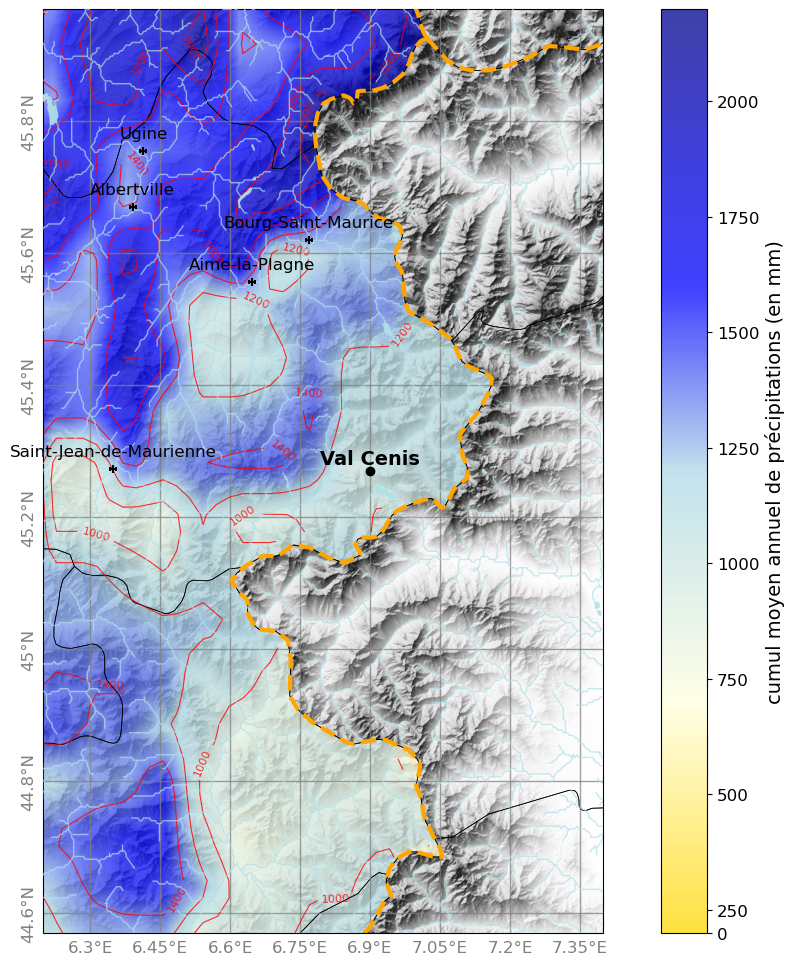

In [64]:
fig, _ = tracer(précipitations_moyennes,titre='cumul moyen annuel de précipitations (en mm)',calcul_valeur_min=True,offset=(-.7,0.5,-.7,0.7),gamma = 1)

In [65]:
fig.savefig(répertoire_résultats+'/'+"précipitations_annuelles_moyennes.png",bbox_inches='tight',dpi=300)

In [66]:
print(f"Le cumul moyen des précipitations sur {nom_poste} est de \
{int(précipitations_moyennes.sel(x=longitude_poste,y=latitude_poste,method="nearest").values )} mm sur la période 1960-{année_en_cours-1}.")

Le cumul moyen des précipitations sur Val Cenis est de 1073 mm sur la période 1960-2024.


# série temporelle

## initialisation

In [67]:
# coordonnées en RGF93 du poste
x_poste, y_poste = latlon_to_lambert.transform(latitude_poste,longitude_poste)

translation_x = 0000 # rajout de 3 km
x_poste       = x_poste+translation_x
param_name = 'PRENEI_Q,PRELIQ_Q,T_Q'
#projection='EPSG:4326'
#coord='POINT('+str(latitude_poste)+" "+str(longitude_poste)+")"
#coord='POINT(1011370 6471230)'
coord      = 'POINT('+str(x_poste)+' '+str(y_poste)+')'
projection = 'EPSG:2154'
formatage  = 'CoverageJSON'
date       = '1960-01-01/2023-12-31'
date       = '1960-01-01/'+str(année_en_cours-1)+'-12-31'
requete    = f'https://api.geosas.fr/edr/collections/safran-isba/position?coords={coord}&crs={projection}&parameter-name={param_name}&f={formatage}&datetime={date}'
print(requete)
r=requests.get(requete, verify=True)
data=r.json()
if r.status_code == 200:
    print("J'ai récupéré les données.")
else :
    print(colored("Il y a une erreur avec le code : {:d}.".format(r.status_code), 'red') )

 

https://api.geosas.fr/edr/collections/safran-isba/position?coords=POINT(1005650.5953364202 6470879.453527486)&crs=EPSG:2154&parameter-name=PRENEI_Q,PRELIQ_Q,T_Q&f=CoverageJSON&datetime=1960-01-01/2024-12-31
J'ai récupéré les données.


## neige

Le maximum a été atteint le 24/11/2016 avec un cumul journalier de 108.3 mm.


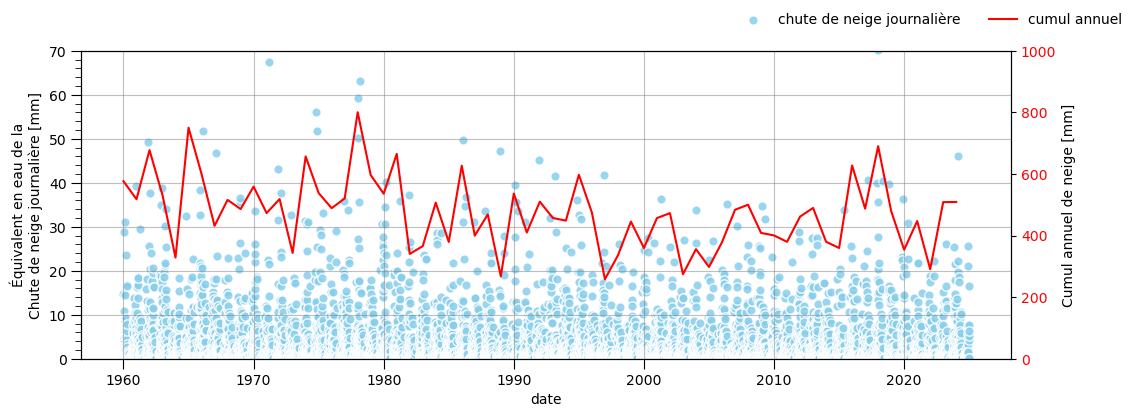

In [81]:
safran_temps=data['domain']['axes']['t']['values']
#values=data['ranges'][param_name]['values']
safran_neige=np.array(data['ranges']['PRENEI_Q']['values'])
série_safran_neige=pd.DataFrame()
série_safran_neige['neige']=safran_neige
série_safran_neige['date']=pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')

cumul_mensuel = série_safran_neige.groupby(by = [série_safran_neige['date'].dt.month, série_safran_neige['date'].dt.year])['neige'].sum() 
dates_cum     = (série_safran_neige.groupby(by = [série_safran_neige['date'].dt.month, série_safran_neige['date'].dt.year]).first())['date']

cumul_annuel = série_safran_neige.groupby(by = [ série_safran_neige['date'].dt.year])['neige'].sum() 
dates_an     = (série_safran_neige.groupby(by = [  série_safran_neige['date'].dt.year]).first())['date']



série_safran_neige = série_safran_neige[série_safran_neige['neige']>0]
# distribution temporelle des distributions
#unité_variable = liste_variables_possibles[ liste_variables_possibles[:, 0] =='PRENEI_Q'][0][2]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(série_safran_neige['date'], série_safran_neige['neige'],marker = "o" , s = 45,
           color='skyblue',edgecolor="white",alpha = 0.85,label = "chute de neige journalière")

ax.set_ylim((0,70))

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

ax.set_ylabel(r'Équivalent en eau de la' '\n' r'Chute de neige journalière [mm]')
ax.set_xlabel(r'date')
max_neige = np.nanmax(safran_neige)
date_max= série_safran_neige[série_safran_neige['neige']==max_neige]['date'] .values[0]   
# le format de données du temps est bizarre il faut supprimer les 10 dernier caractères
date_max=datetime.datetime.strptime(str(date_max)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_neige))   
plt.grid(True, color = 'gray', alpha=0.5)

ax2 = ax.twinx()   

# tracé des cumul
color = 'red'
ax2.set_ylim((0,1000))
ax2.set_ylabel('Cumul annuel de neige [mm]' )   
ax2.plot(dates_an, cumul_annuel, color=color, alpha = 1, linewidth = 1.5, 
         label = "cumul annuel")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc="upper right", ncol=2,frameon=False)

fig.savefig(répertoire_résultats+'/'+'chronique_neige_safran.png',bbox_inches='tight',dpi=300)


In [69]:
print(f"La moyenne interannuelle du cumul annuel est {int(cumul_annuel.mean())} mm et l'écart-type est {int(np.std(cumul_annuel))} mm.")
print(f"Le maximum du cumul annuel est {int(cumul_annuel.max())} mm.")

La moyenne interannuelle du cumul annuel est 474 mm et l'écart-type est 116 mm.
Le maximum du cumul annuel est 800 mm.


In [70]:
# export au format CVS
(série_safran_neige[['date','neige']].fillna(value=0)).to_csv('données_safran_neige.csv', sep='\t', encoding='utf-8',index = False)

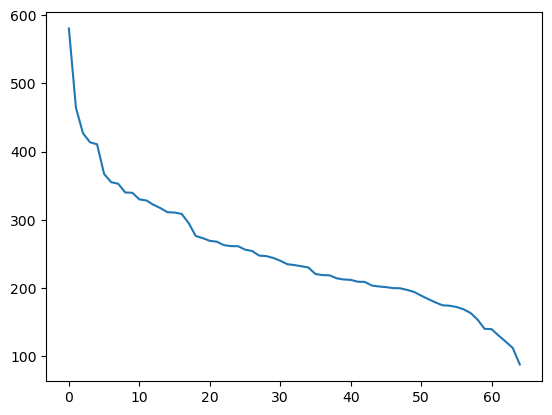

In [71]:
hiver = série_safran_neige[série_safran_neige['date'].dt.month <= 4]
cumul_hiver = np.array(hiver['neige'].groupby(by=hiver['date'].dt.year).sum())
cumul_hiver_trié = np.sort(cumul_hiver)[::-1]
np.where(cumul_hiver_trié == cumul_hiver[-1])
plt.plot(cumul_hiver_trié)

In [72]:
cumul_annuel_max = np.nanmax(cumul_annuel)
cumul_annuel_min = np.nanmin(cumul_annuel)
cumul_annuel_moy = np.nanmean(np.delete(cumul_annuel,-1))
print(f"Le cumul maximal est {int(cumul_annuel_max)} mm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_max].index )[0]}.")
print(f"Le cumul minimal est {int(cumul_annuel_min)} mm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_min].index )[0]}.")
print(f"Le cumul moyen est {int(cumul_annuel_moy)} mm.")

Le cumul maximal est 800 mm et a été observé en 1978.
Le cumul minimal est 258 mm et a été observé en 1997.
Le cumul moyen est 473 mm.


In [73]:
nom_figure = f"Safran_Cumul-annuel-neige_{nom_commune}.png"
 
fig.savefig(nom_figure,bbox_inches='tight',dpi=300)

## cumul précipitations liquides

Le maximum a été atteint le 31/03/1981 avec un cumul journalier de 113.6 mm.


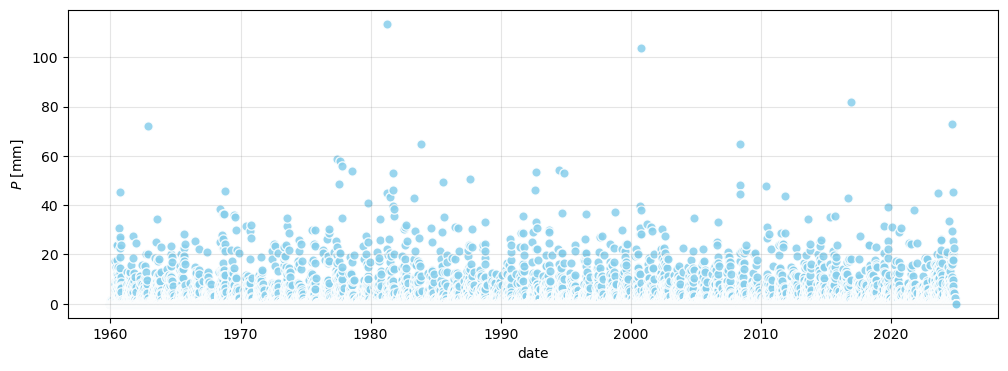

In [74]:
safran_temps=data['domain']['axes']['t']['values']
#values=data['ranges'][param_name]['values']
safran_pluie=np.array(data['ranges']['PRELIQ_Q']['values'])
série_safran_pluie=pd.DataFrame()
série_safran_pluie['pluie']=safran_pluie
série_safran_pluie['date']=pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')

# distribution temporelle des distributions
#unité_variable = liste_variables_possibles[ liste_variables_possibles[:, 0] =='PRENEI_Q'][0][2]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(série_safran_pluie['date'], série_safran_pluie['pluie'],marker = "o" , s = 45,
           color='skyblue',edgecolor="white",alpha = 0.85)
ax.set_ylabel(r'$P$ [mm]')
ax.set_xlabel(r'date')
max_pluie = np.nanmax(safran_pluie)
date_max  = série_safran_pluie[série_safran_pluie['pluie']==max_pluie]['date'] .values[0]   
# le format de données du temps est bizarre il faut supprimer les 10 dernier caractères
date_max=datetime.datetime.strptime(str(date_max)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_pluie))   
plt.grid(True, color = 'gray', alpha=0.2)

In [75]:
# export au format CVS
(série_safran_pluie[['date','pluie']].fillna(value=0)).to_csv('données_safran.csv', sep='\t', encoding='utf-8' ,index = False)

In [76]:
série_safran_pluie.date

0       1960-01-01
1       1960-01-02
2       1960-01-03
3       1960-01-04
4       1960-01-05
           ...    
23737   2024-12-27
23738   2024-12-28
23739   2024-12-29
23740   2024-12-30
23741   2024-12-31
Name: date, Length: 23742, dtype: datetime64[ns]

In [77]:
série_safran_pluie = série_safran_pluie[série_safran_pluie.date<"2024-01-01"]
cumul_annuel = série_safran_pluie.groupby(by = [ série_safran_pluie['date'].dt.year])['pluie'].sum() 
dates_an     = (série_safran_pluie.groupby(by = [  série_safran_pluie['date'].dt.year]).first())['date']

In [78]:
cumul_annuel_max = np.nanmax(cumul_annuel)
cumul_annuel_min = np.nanmin(cumul_annuel)
cumul_annuel_moy = np.nanmean(np.delete(cumul_annuel,-1))
print(f"Le cumul maximal est {int(cumul_annuel_max)} mm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_max].index )[0]}.")
print(f"Le cumul minimal est {int(cumul_annuel_min)} mm et a été observé en {np.array(cumul_annuel[cumul_annuel==cumul_annuel_min].index )[0]}.")
print(f"Le cumul moyen est {int(cumul_annuel_moy)} mm.")

Le cumul maximal est 869 mm et a été observé en 1981.
Le cumul minimal est 255 mm et a été observé en 1989.
Le cumul moyen est 491 mm.


In [79]:
assemblage=pd.concat([série_safran_neige,série_safran_pluie],axis=1) 
assemblage[['date','neige','pluie']].to_csv("safran.csv",index = False)

## cumul de précipitations totales

Le maximum a été atteint le 24/11/2016 avec un cumul journalier de 190.2 mm.


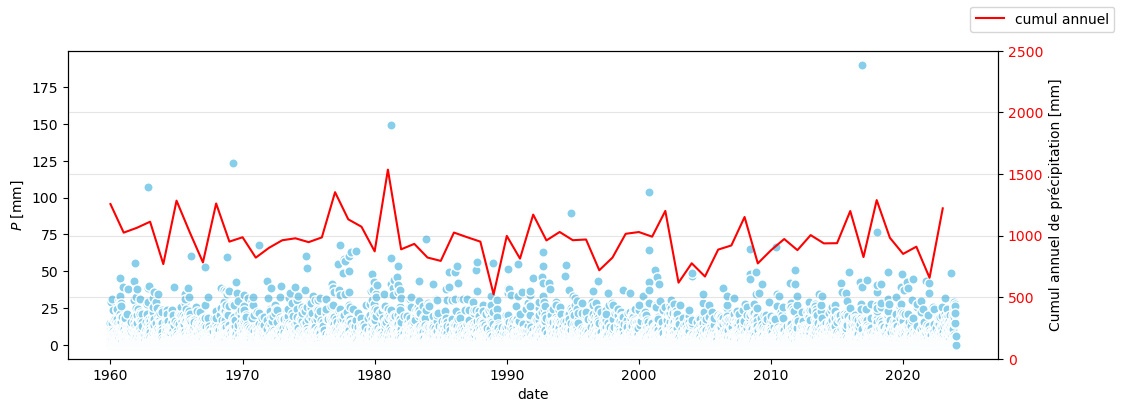

In [83]:
safran_temps         = data['domain']['axes']['t']['values']
safran_précipitation = np.array(data['ranges']['PRELIQ_Q']['values'])+np.array(data['ranges']['PRENEI_Q']['values'])
série_safran_précipitation = pd.DataFrame()
série_safran_précipitation['précipitation'] = safran_précipitation
série_safran_précipitation['date']          = pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')
série_safran_précipitation = série_safran_précipitation[série_safran_précipitation.date<"2024-01-01"]
cumul_annuel = série_safran_précipitation.groupby(by = [ série_safran_précipitation['date'].dt.year])['précipitation'].sum() 
dates_an     = (série_safran_précipitation.groupby(by = [  série_safran_précipitation['date'].dt.year]).first())['date']
 


# distribution temporelle des distributions
#unité_variable = liste_variables_possibles[ liste_variables_possibles[:, 0] =='PRENEI_Q'][0][2]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(série_safran_précipitation['date'], série_safran_précipitation['précipitation'],  marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'$P$ [mm]')
ax.set_xlabel(r'date')

ax2 = ax.twinx()   

# tracé des cumuls annuels
color = 'red'
ax2.set_ylim((0,2500))
ax2.set_ylabel('Cumul annuel de précipitation [mm]' )   
ax2.plot(dates_an, cumul_annuel, color=color, alpha = 1, linewidth = 1.5, 
         label = "cumul annuel")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc="upper right")

fig.savefig(répertoire_résultats+'/'+'chronique_précipitations-totales_safran.png',bbox_inches='tight',dpi=300)


max_précipitation = np.nanmax(safran_précipitation)
date_max  = série_safran_précipitation[série_safran_précipitation['précipitation']==max_précipitation]['date'] .values[0]   
# le format de données du temps est bizarre il faut supprimer les 10 dernier caractères
date_max=datetime.datetime.strptime(str(date_max)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_précipitation))   
plt.grid(True, color = 'gray', alpha=0.2)

## Température

Le maximum a été atteint le 27/06/2019 avec une température journalière de 20.5 °C.
Le minimum a été atteint le 09/02/1986 avec une température journalière de -20.8 °C.
La moyenne est de 2.4 °C.
Le gradient de température 2.31 °C/siècle.


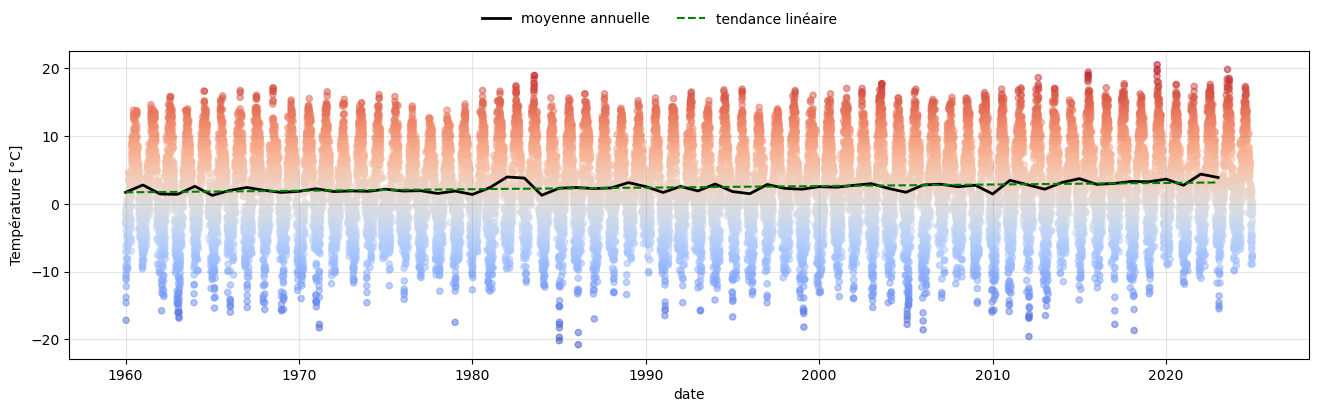

In [86]:
safran_temps = data['domain']['axes']['t']['values']
#values=data['ranges'][param_name]['values']
safran_temperature = np.array(data['ranges']['T_Q']['values'])
série_safran_temp  = pd.DataFrame()
série_safran_temp['temp'] = safran_temperature
série_safran_temp['date'] = pd.to_datetime(safran_temps, format='%Y-%m-%dT%H-%M-%SZ')



# distribution temporelle des distributions
#unité_variable = liste_variables_possibles[ liste_variables_possibles[:, 0] =='PRENEI_Q'][0][2]

# Make a user-defined colormap.
cm1 = mcolors.LinearSegmentedColormap.from_list("MyCmapName",["lightskyblue","red"])
cnorm = mcolors.Normalize(vmin=-10,vmax=15)

fig, ax = plt.subplots(figsize=(16,4))
ax.scatter(série_safran_temp['date'], série_safran_temp['temp'],marker = "o",c=série_safran_temp['temp'],cmap='coolwarm',s=20,   alpha = 0.5)
ax.set_ylabel(r'Température [°C]')
ax.set_xlabel(r'date')

plt.grid(True, color = 'gray', alpha=0.2)

température_annuelle  = np.delete(np.array(série_safran_temp.groupby(by = [série_safran_temp['date'].dt.year])['temp'].mean()),-1)
dates_température_an  = np.delete(np.array((série_safran_temp.groupby(by = [  série_safran_temp['date'].dt.year ]).first())['date']),-1)
import matplotlib.dates as mdates  # un conflit de format de dates entre numpy et 
slope, intercept, r_value, p_value, std_err = stats.linregress(mdates.date2num(dates_température_an) , température_annuelle )
trendline = intercept + slope*mdates.date2num(dates_température_an) 

ax.plot(dates_température_an,température_annuelle,label="moyenne annuelle", linewidth = 2, color = 'black')
ax.plot(dates_température_an,trendline,label="tendance linéaire", linestyle = '--', color = 'green')

fig.legend(loc="upper center",frameon=False,ncol=2)
max_temperature = np.nanmax(safran_temperature)
min_temperature = np.nanmin(safran_temperature)
moy_temperature = np.nanmean(safran_temperature)
date_max  = série_safran_temp[série_safran_temp['temp']==max_temperature]['date'] .values[0]   
date_min  = série_safran_temp[série_safran_temp['temp']==min_temperature]['date'] .values[0]  
# le format de données du temps est bizarre il faut supprimer les 10 dernier caractères
date_max=datetime.datetime.strptime(str(date_max)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
date_min=datetime.datetime.strptime(str(date_min)[:-10] ,"%Y-%m-%dT%H:%M:%S").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec une température journalière de {:.1f} °C.".format(max_temperature))   
print("Le minimum a été atteint le "+date_min+" avec une température journalière de {:.1f} °C.".format(min_temperature)) 
print("La moyenne est de {:.1f} °C.".format(moy_temperature)) 
print("Le gradient de température {:.2f} °C/siècle.".format(100*slope*365)) 

In [87]:
nom_figure=f"Safran_Evolution_température_1960-24_{nom_commune}.png"
 
#fig.savefig(nom_figure,bbox_inches='tight')
fig.savefig(répertoire_résultats+'/'+nom_figure ,bbox_inches='tight',dpi=300)